In [75]:
import pandas as pd
import numpy as np
import json
import os
import networkx as nx

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.preprocessing import LabelEncoder

from myclass.CleanMergeDataset import Clean_Merge_Dataset
from myclass.BonferroniTtest import Bonferroni_Ttest

In [2]:
if os.path.exists('final_dataset_common.json') is False:

    data_normal = pd.read_pickle('./data-ready/RNA_dataframe_normal').replace('/', '\\')
    data_tumor = pd.read_pickle('./data-ready/RNA_dataframe').replace('/', '\\')
    dataset_RNA, y_RNA, cases_id_RNA = Clean_Merge_Dataset(name='RNA').transform(data_normal, data_tumor)
    df_RNA = pd.concat([dataset_RNA, cases_id_RNA], axis=1)

    data_normal = pd.read_pickle('./data-ready/miRNA_dataframe_normal').replace('/', '\\')
    data_tumor = pd.read_pickle('./data-ready/miRNA_dataframe').replace('/', '\\')
    dataset_miRNA, y_miRNA, cases_id_miRNA= Clean_Merge_Dataset(name='miRNA').transform(data_normal, data_tumor)
    df_miRNA = pd.concat([dataset_miRNA, cases_id_miRNA], axis=1)

    data_normal = pd.read_pickle('./data-ready/illumina-27-450-normal').replace('/', '\\')
    data_tumor = pd.read_pickle('./data-ready/illumina450-27-tumor').replace('/', '\\')
    dataset_illumina, y_illumina, cases_id_illumina= Clean_Merge_Dataset(name='illumina').transform(data_normal, data_tumor)
    df_illumina = pd.concat([dataset_illumina, cases_id_illumina], axis=1)

    dataset_RNA = Bonferroni_Ttest(label_case_id_into_X=True, alpha=0.05).fit_transform(pd.concat([df_RNA, y_RNA], axis=1), y_RNA)
    dataset_miRNA = Bonferroni_Ttest(label_case_id_into_X=True, alpha=0.05).fit_transform(pd.concat([df_miRNA, y_miRNA], axis=1), y_miRNA)
    dataset_illumina = Bonferroni_Ttest(label_case_id_into_X=True, alpha=0.05).fit_transform(pd.concat([df_illumina, y_illumina], axis=1), y_illumina)

    cases_id = set(dataset_illumina['case_id']) & set(dataset_miRNA['case_id']) & set(dataset_RNA['case_id'])
    df_final_illumina = dataset_illumina.loc[dataset_illumina['case_id'].isin(cases_id)]
    df_final_rna = dataset_RNA.loc[dataset_RNA['case_id'].isin(cases_id)]
    df_final_mirna = dataset_miRNA.loc[dataset_miRNA['case_id'].isin(cases_id)]

    print(df_final_illumina.shape)
    print(df_final_rna.shape)
    print(df_final_mirna.shape)
    
    df_final_illumina.to_pickle('illumina_pickle.pkl')
    df_final_rna.to_pickle('rna_pickle.pkl')
    df_final_mirna.to_pickle('miRNA_pickle.pkl')
    
    my_dict = {
        'miRNA': df_final_mirna.to_dict(),
        'RNA': df_final_rna.to_dict(),
        'illumina': df_final_illumina.to_dict()
    }
    with open('final_dataset_common.json', 'w') as outfile:
        json.dump(my_dict, outfile)
    
    df_illumina = df_final_illumina.copy()
    df_mirna = df_final_mirna.copy()
    df_rna = df_final_rna.copy()
    
    del my_dict
    del df_final_illumina
    del df_final_rna
    del df_final_mirna
    del dataset_illumina
    del dataset_RNA
    del dataset_miRNA
else:
    df_illumina = pd.read_pickle('illumina_pickle.pkl')
    df_mirna = pd.read_pickle('miRNA_pickle.pkl')
    df_rna = pd.read_pickle('rna_pickle.pkl')

In [3]:
import numpy as np
import pandas as pd

from scipy.spatial.distance import pdist, squareform
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

class SimilarityNetworkFusion:
    def __init__(self, df_mirna, df_rna, df_illumina, k=3, mu=0.3):
        
        self.cases_id = df_rna.loc[:, 'case_id']
        self.rna = df_rna.copy()
        self.mirna = df_mirna.copy()
        self.illumina = df_illumina.copy()
        
        self.k = k
        self.mu = mu
        self.check_columns()
    
    def calculate_matrix(self):
        if hasattr(self, 'w_rna') is False:
            self.w_rna = self.__weights__(self.rna, 'RNA')
            self.w_mirna = self.__weights__(self.mirna, 'miRNA')
            self.w_illumina = self.__weights__(self.illumina, 'Illumina')
        
        if hasattr(self, 'p_rna') is False:
            self.p_rna = self.P_matrix(self.w_rna.to_numpy().tolist(), self.cases_id.shape[0], 'RNA')
            self.p_mirna = self.P_matrix(self.w_mirna.to_numpy().tolist(), self.cases_id.shape[0], 'miRNA')
            self.p_illumina = self.P_matrix(self.w_illumina.to_numpy().tolist(), self.cases_id.shape[0], 'Illumina')

        self.s_rna = self.S_matrix(self.w_rna.to_numpy().tolist(), self.cases_id.shape[0], 'RNA')
        self.s_mirna = self.S_matrix(self.w_mirna.to_numpy().tolist(), self.cases_id.shape[0], 'miRNA')
        self.s_illumina = self.S_matrix(self.w_illumina.to_numpy().tolist(), self.cases_id.shape[0], 'Illumina')
        
        return self
        

    def __weights__(self, dataset, name):
        print('Calculating weights for {}...'.format(name))
        df = pd.DataFrame(columns=self.cases_id, data=dataset.T.values)
        
        #calculate euclidean distance
        dist = pdist(dataset, 'euclidean')
        self.df_dist = pd.DataFrame(columns=self.cases_id, index=self.cases_id, data=squareform(dist))
        weights = pd.DataFrame(columns=self.cases_id, index=self.cases_id, data=[])
                
        for i, patient_i in enumerate(tqdm(self.cases_id)):
            for patient_j in self.cases_id.iloc[i:]:
                    tokK_mean_i = np.sort(self.df_dist.loc[patient_i, :].to_numpy())[:self.k].mean()
                    topK_mean_j = np.sort(self.df_dist.loc[patient_j, :].to_numpy())[:self.k].mean()
                    
                    eps = (tokK_mean_i + tokK_mean_i + self.df_dist.loc[patient_i, patient_j])/3

                    weights.loc[patient_i, patient_j] = np.exp(-(self.df_dist.loc[patient_i, patient_j]**2/(eps*self.mu)))
                    weights.loc[patient_j, patient_i] = np.exp(-(self.df_dist.loc[patient_j, patient_i]**2/(eps*self.mu)))
                    
        return weights       
    
    def check_columns(self):
        scaler = MinMaxScaler()
        if 'label' in self.mirna.columns:
            self.mirna.drop(['label'], axis=1, inplace=True)
        if 'case_id' in self.mirna.columns:
            self.mirna.drop(['case_id'], axis=1, inplace=True)
            
        if 'label' in self.rna.columns:
            self.rna.drop(['label'], axis=1, inplace=True)
        if 'case_id' in self.rna.columns:
            self.rna.drop(['case_id'], axis=1, inplace=True)
            
        if 'label' in self.illumina.columns:
            self.illumina.drop(['label'], axis=1, inplace=True)
        if 'case_id' in self.illumina.columns:
            self.illumina.drop(['case_id'], axis=1, inplace=True)
            
        self.mirna = pd.DataFrame(scaler.fit_transform(self.mirna))
        self.rna = pd.DataFrame(scaler.fit_transform(self.rna))
        self.illumina = pd.DataFrame(scaler.fit_transform(self.illumina))

        return


    def find_k_neighbors(self, row, i, k=None): 
        row=deepcopy(row)
        #case of P matrix
        if k==None:
            del row[i]  #delete element of the same column of row index
            return row

        #case of S (find k elements with minimum distance value of W[i][j])
        else:
            k_neighbors_index=[]
            neigh = 0
            max_value = max(row)
            for j in range(0, len(row)):
                if j!=i:
                    min_index = row.index(min(row))
                    k_neighbors_index.append(min_index)
                    neigh+=1
                    row[min_index] = max_value
                    if neigh == k:
                        return k_neighbors_index


    def P_matrix(self, W, n_case_id, name):
        print('Calculating P matrix for {}...'.format(name))
        P=[]
        for i in tqdm(range(0, n_case_id)):
            row=[]
            for j in range(0,n_case_id):
                if i==j:
                    row.append(1/2)

                else:
                    k_neighbors = self.find_k_neighbors(W[i], i)
                    denominator = 2*sum(k_neighbors)
                    row.append(W[i][j]/denominator)
            P.append(row)
        print(np.array(P))
        return np.array(P)

    def S_matrix(self, W, n_case_id, name):
        print('Calculating S matrix for {}...'.format(name))
        S=[]
        for i in tqdm(range(0, n_case_id)):
            S_row=[]
            neighbors_indeces = self.find_k_neighbors(self.df_dist.iloc[i,:].to_numpy().tolist(), i, self.k)
            for j in range(0,n_case_id):
                if j not in neighbors_indeces:
                    S_row.append(0)

                else:
                    np_row = np.array(W[i])
                    denominator = sum(np_row[neighbors_indeces])
                    S_row.append(W[i][j]/denominator)
            S.append(S_row)
        print(np.array(S))
        return np.array(S)
    
    def product_matrix(self, S_matrix, P_matrix):
        result = np.dot(S_matrix, P_matrix)
        result = np.dot(result, S_matrix.T)
        return result
    
    def sum_matrix_P(self, P1, P2):
        return np.add(P1,P2)/2
    
    def fit(self, num_iter=None):
        if num_iter is not None:
            for i in range(0, num_iter):
                self.p_rna_t1 = self.product_matrix(self.s_rna, self.sum_matrix_P(self.p_mirna, self.p_illumina))
                self.p_mirna_t1 = self.product_matrix(self.s_mirna, self.sum_matrix_P(self.p_rna, self.p_illumina))
                self.p_illumina_t1 = self.product_matrix(self.s_illumina, self.sum_matrix_P(self.p_mirna, self.p_rna))
                print(self.p_rna_t1)
                print(self.p_mirna_t1)
                print(self.p_illumina_t1)
                self.p_rna = self.p_rna_t1
                self.p_mirna = self.p_mirna_t1
                self.p_illumina = self.p_illumina_t1
        else:
            print('ciao')

        return self
    
    def clean(self):
        del self.p_rna
        del self.p_mirna
        del self.p_illumina
        
        del self.p_rna_t1
        del self.p_mirna_t1
        del self.p_illumina_t1
        
        
        del self.w_rna
        del self.w_mirna
        del self.w_illumina
        
        return self

In [4]:
df_mirna.sort_values(by='case_id', inplace=True)
df_rna.sort_values(by='case_id', inplace=True)
df_illumina.sort_values(by='case_id', inplace=True)

sm = SimilarityNetworkFusion(df_mirna.drop_duplicates(subset='case_id'),
                            df_rna.drop_duplicates(subset='case_id'),
                            df_illumina.drop_duplicates(subset='case_id'), k=100).calculate_matrix()

Calculating weights for RNA...


  0%|          | 0/449 [00:00<?, ?it/s]

Calculating weights for miRNA...


100%|██████████| 449/449 [01:38<00:00,  4.58it/s]


Calculating weights for Illumina...


  0%|          | 0/449 [00:00<?, ?it/s]

Calculating P matrix for RNA...


  0%|          | 0/449 [00:00<?, ?it/s]

[[5.00000000e-01 5.57150677e-16 1.39763524e-16 ... 5.28993010e-15
  5.55991034e-28 3.28982971e-06]
 [1.39388110e-12 5.00000000e-01 1.96092903e-13 ... 1.52924545e-15
  3.37501257e-14 1.28255930e-18]
 [3.35451522e-11 1.88124228e-11 5.00000000e-01 ... 2.40455260e-13
  1.42527669e-24 9.31355444e-13]
 ...
 [1.11154138e-13 1.28439863e-17 2.10510645e-17 ... 5.00000000e-01
  1.66602793e-27 2.03632237e-17]
 [3.15614858e-17 7.65794035e-07 3.37095467e-19 ... 4.50086750e-18
  5.00000000e-01 3.35465634e-18]
 [8.77390304e-14 1.36723700e-29 1.03490134e-25 ... 2.58458157e-26
  1.57607833e-36 5.00000000e-01]]
Calculating P matrix for miRNA...


  0%|          | 0/449 [00:00<?, ?it/s]

[[5.00000000e-01 1.65126674e-06 1.43105641e-03 ... 1.26894040e-03
  2.70502585e-07 1.45364865e-03]
 [2.37509594e-05 5.00000000e-01 4.17742784e-03 ... 1.03010617e-04
  1.37146412e-04 1.83278401e-04]
 [4.88520300e-04 9.91450179e-05 5.00000000e-01 ... 2.18685770e-04
  8.82187938e-08 2.42800831e-03]
 ...
 [4.56052919e-04 2.57390242e-06 2.30233585e-04 ... 5.00000000e-01
  8.25579787e-09 1.64637505e-03]
 [5.61553777e-05 1.97943142e-03 5.36482038e-05 ... 4.76875455e-06
  5.00000000e-01 1.35609995e-03]
 [3.19187096e-04 2.79790678e-06 1.56174521e-03 ... 1.00586718e-03
  1.43435828e-06 5.00000000e-01]]
Calculating P matrix for Illumina...


  2%|▏         | 8/449 [00:00<00:05, 73.52it/s]

[[5.00000000e-001 1.94525455e-030 2.03100094e-102 ... 3.20702797e-045
  7.59048158e-046 2.14527554e-044]
 [1.02921975e-017 5.00000000e-001 3.62030681e-091 ... 2.13744681e-029
  1.18709179e-013 4.18967537e-040]
 [2.91678766e-084 9.82671580e-086 5.00000000e-001 ... 4.78968266e-041
  2.23250501e-069 3.06567305e-099]
 ...
 [5.99139186e-029 7.54724804e-026 6.23070269e-043 ... 5.00000000e-001
  3.44979403e-021 1.21278750e-053]
 [9.32387809e-029 2.75600428e-009 1.90952351e-070 ... 2.26827364e-020
  5.00000000e-001 6.03391227e-047]
 [2.14150432e-041 7.90468518e-050 2.13091940e-114 ... 6.48030743e-067
  4.90351615e-061 5.00000000e-001]]
Calculating S matrix for RNA...


  2%|▏         | 8/449 [00:00<00:05, 75.43it/s]

[[1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.61447414e-31 0.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [8.81446815e-20 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 9.99999771e-01]]
Calculating S matrix for miRNA...


  2%|▏         | 9/449 [00:00<00:04, 89.40it/s]

[[9.53624077e-01 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.92785206e-01 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 8.89281659e-01 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.27827171e-01
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 3.84302822e-06 0.00000000e+00 ... 0.00000000e+00
  9.99298906e-01 0.00000000e+00]
 [4.53047009e-04 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 7.72727170e-01]]
Calculating S matrix for Illumina...


100%|██████████| 449/449 [00:05<00:00, 86.67it/s]

[[1.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.69620492e-35 0.00000000e+00 ... 0.00000000e+00
  1.00000000e+00 0.00000000e+00]
 [1.62184284e-53 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 1.00000000e+00]]


In [80]:
import plotly.graph_objects as go

def plot_starting_graphs(df, y_pred):
    G = nx.from_numpy_matrix(df)
    print(nx.info(G))
    nx.draw_networkx(G, with_labels=False)
    return

Name: 
Type: Graph
Number of nodes: 449
Number of edges: 101025
Average degree: 450.0000


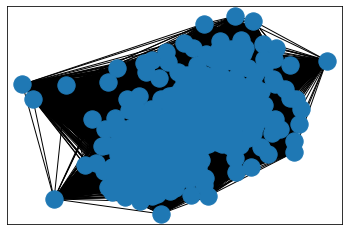

In [81]:
plot_starting_graphs(sm.p_rna, y_pred)

In [47]:
sm.fit(num_iter=50)

[[5.00000000e-01 8.25633369e-07 7.15528204e-04 ... 6.34470201e-04
  1.35251292e-07 7.26824931e-04]
 [1.18754797e-05 5.00000000e-01 2.08871392e-03 ... 5.15053084e-05
  6.85732060e-05 9.16392303e-05]
 [2.44260150e-04 4.95725089e-05 5.00000000e-01 ... 1.09342885e-04
  4.41093969e-08 1.21400411e-03]
 ...
 [2.28026460e-04 1.28695121e-06 1.15116793e-04 ... 5.00000000e-01
  4.12789893e-09 8.23187354e-04]
 [2.80776889e-05 9.89717087e-04 2.68241019e-05 ... 2.38437728e-06
  5.00000000e-01 6.78049830e-04]
 [1.59593812e-04 1.39895833e-06 7.80872907e-04 ... 5.02933504e-04
  7.17180741e-07 4.99999781e-01]]
[[4.55179803e-01 1.76498731e-06 1.84978943e-04 ... 1.24834719e-05
  1.43710348e-06 1.76593685e-03]
 [7.47071483e-05 4.93055324e-01 1.13063207e-08 ... 2.62355134e-05
  3.62177844e-06 1.63835448e-04]
 [5.16663786e-06 1.03928356e-07 3.96126431e-01 ... 4.02644102e-05
  2.07129074e-08 2.05656236e-05]
 ...
 [1.39219342e-05 6.16473053e-07 5.71525351e-05 ... 3.60452441e-01
  7.53628317e-09 3.08356998e-05]

[[3.74774044e-01 3.46612949e-05 9.51333749e-04 ... 8.51704643e-04
  3.79712752e-06 3.85906586e-03]
 [2.75155447e-04 4.78544113e-01 1.08244199e-03 ... 1.42764370e-04
  5.63295306e-05 7.59277078e-04]
 [2.75071566e-04 3.48891161e-05 2.50923299e-01 ... 8.20571312e-04
  2.27319383e-07 9.67808759e-04]
 ...
 [3.57749580e-04 1.14835694e-05 8.37853120e-04 ... 1.82339707e-01
  2.00082429e-07 6.74593889e-04]
 [8.98402502e-05 8.02972719e-04 1.46637210e-05 ... 1.11137646e-05
  4.97848618e-01 3.37467611e-04]
 [2.24121433e-03 7.34194904e-05 7.15238126e-04 ... 5.42606522e-04
  1.53007286e-06 1.18300691e-01]]
[[3.52053459e-01 4.85842887e-05 1.03988827e-03 ... 1.00441896e-03
  4.66197678e-06 4.33877706e-03]
 [3.41422722e-04 4.74045916e-01 1.02305363e-03 ... 1.67518596e-04
  5.87530210e-05 9.33743187e-04]
 [3.08439279e-04 3.56291797e-05 2.15779851e-01 ... 1.08481230e-03
  2.84827206e-07 9.81147412e-04]
 ...
 [4.36400085e-04 1.55601284e-05 1.09524416e-03 ... 1.45143110e-01
  2.74232390e-07 7.61969083e-04]

  4.03833431e-06 4.43413801e-02]]
[[2.83968095e-01 1.16096455e-04 1.30919997e-03 ... 1.54024767e-03
  8.09444522e-06 5.49564880e-03]
 [5.92811368e-04 4.58625257e-01 8.41038758e-04 ... 2.58500965e-04
  6.67636668e-05 1.53625686e-03]
 [4.52905375e-04 3.93456837e-05 1.30770160e-01 ... 2.08301978e-03
  5.07975164e-07 1.02156813e-03]
 ...
 [7.60949816e-04 3.58602525e-05 2.05930947e-03 ... 6.96235799e-02
  6.74090210e-07 1.13817873e-03]
 [1.58781100e-04 8.74132024e-04 1.32795897e-05 ... 2.66475897e-05
  4.95782817e-01 3.69324530e-04]
 [3.73041774e-03 2.34882885e-04 8.06614746e-04 ... 1.03240519e-03
  4.99010183e-06 3.37997996e-02]]
[[3.02218428e-01 9.49083732e-05 1.23572394e-03 ... 1.39158593e-03
  7.07099789e-06 5.21465484e-03]
 [5.19421141e-04 4.62992035e-01 8.88607791e-04 ... 2.31860492e-04
  6.44469498e-05 1.36823654e-03]
 [4.08130038e-04 3.80321377e-05 1.51591226e-01 ... 1.80056251e-03
  4.40874815e-07 1.00726035e-03]
 ...
 [6.64899336e-04 2.93592668e-05 1.78663972e-03 ... 8.67113851e-0

[[2.29534112e-01 2.04595246e-04 1.54083386e-03 ... 1.99765243e-03
  1.20701194e-05 6.16475996e-03]
 [8.58650419e-04 4.43686211e-01 7.09436624e-04 ... 3.57133645e-04
  7.49055449e-05 2.06937842e-03]
 [6.34686412e-04 4.68219194e-05 8.06341124e-02 ... 2.96335660e-03
  7.91792047e-07 1.10086662e-03]
 ...
 [1.10526104e-03 6.48276284e-05 2.91192154e-03 ... 3.53846413e-02
  1.33613928e-06 1.52139770e-03]
 [2.14202579e-04 9.08041238e-04 1.41233462e-05 ... 4.27078542e-05
  4.94181212e-01 4.43841108e-04]
 [4.54827952e-03 3.89961500e-04 9.13927431e-04 ... 1.42714086e-03
  9.22468681e-06 1.71743220e-02]]
[[2.15770665e-01 2.32449020e-04 1.60256889e-03 ... 2.11345651e-03
  1.32886158e-05 6.30730575e-03]
 [9.35644471e-04 4.39491265e-01 6.78980444e-04 ... 3.86402556e-04
  7.72357976e-05 2.20821472e-03]
 [6.90847446e-04 4.97113310e-05 6.99313652e-02 ... 3.18277120e-03
  8.88209645e-07 1.12993838e-03]
 ...
 [1.20249249e-03 7.43980903e-05 3.12546984e-03 ... 2.91039810e-02
  1.57234527e-06 1.62569488e-03]

[[1.97185372e-01 2.76986041e-04 1.69035275e-03 ... 2.26862421e-03
  1.52195450e-05 6.47481706e-03]
 [1.05156866e-03 4.33293179e-01 6.42069449e-04 ... 4.31588049e-04
  8.07344504e-05 2.39866985e-03]
 [7.79152301e-04 5.51672696e-05 5.74193054e-02 ... 3.46683248e-03
  1.05959398e-06 1.18103065e-03]
 ...
 [1.34465182e-03 9.03564970e-05 3.40353500e-03 ... 2.26464550e-02
  1.99239760e-06 1.77318376e-03]
 [2.54276807e-04 9.26478390e-04 1.60249923e-05 ... 5.57841814e-05
  4.93039907e-01 5.03690922e-04]
 [5.00191166e-03 5.04857174e-04 1.01389075e-03 ... 1.68739776e-03
  1.28501002e-05 1.25228804e-02]]
[[1.85419316e-01 3.07457636e-04 1.74747090e-03 ... 2.36632665e-03
  1.65400029e-05 6.57446527e-03]
 [1.12878709e-03 4.29192339e-01 6.20244116e-04 ... 4.62099235e-04
  8.30674927e-05 2.51984348e-03]
 [8.39034105e-04 5.92104245e-05 5.00153227e-02 ... 3.64127392e-03
  1.18463059e-06 1.21728640e-03]
 ...
 [1.43781567e-03 1.01505896e-04 3.57487268e-03 ... 1.90321871e-02
  2.29534244e-06 1.86827990e-03]

[[1.64502677e-01 3.71486075e-04 1.85593740e-03 ... 2.53790781e-03
  1.93252829e-05 6.72796734e-03]
 [1.28233773e-03 4.21130257e-01 5.88575378e-04 ... 5.24710924e-04
  8.77349035e-05 2.73718670e-03]
 [9.62335864e-04 6.92040850e-05 3.87956430e-02 ... 3.92613818e-03
  1.48956746e-06 1.29850477e-03]
 ...
 [1.61625636e-03 1.26006570e-04 3.85721095e-03 ... 1.42580554e-02
  3.00670717e-06 2.04405744e-03]
 [3.02272206e-04 9.44488566e-04 1.99961726e-05 ... 7.29137836e-05
  4.91673415e-01 5.74024836e-04]
 [5.43216308e-03 6.41971429e-04 1.15445004e-03 ... 1.96926665e-03
  1.77230466e-05 1.01482077e-02]]
[[1.54755301e-01 4.04264407e-04 1.90864402e-03 ... 2.61735799e-03
  2.07592175e-05 6.79393380e-03]
 [1.35862657e-03 4.17140728e-01 5.76118075e-04 ... 5.56431341e-04
  9.00684813e-05 2.83882958e-03]
 [1.02467325e-03 7.48007471e-05 3.40354526e-02 ... 4.05082757e-03
  1.66095935e-06 1.34127449e-03]
 ...
 [1.70291870e-03 1.38878624e-04 3.98159724e-03 ... 1.23821944e-02
  3.39483428e-06 2.12774055e-03]

[[1.25686420e-01 5.23728683e-04 2.08253634e-03 ... 2.85253562e-03
  2.60871275e-05 6.95846819e-03]
 [1.62002201e-03 4.03505496e-01 5.57314672e-04 ... 6.70151245e-04
  9.82306742e-05 3.14382728e-03]
 [1.24541762e-03 9.93364581e-05 2.25441032e-02 ... 4.36382289e-03
  2.43441464e-06 1.50415874e-03]
 ...
 [1.98544388e-03 1.88504150e-04 4.29961572e-03 ... 8.55018600e-03
  5.01697375e-06 2.38968666e-03]
 [3.72673330e-04 9.66324523e-04 2.96702570e-05 ... 1.00796941e-04
  4.89630029e-01 6.66865727e-04]
 [5.90328751e-03 8.39844378e-04 1.39226929e-03 ... 2.33204015e-03
  2.58154130e-05 8.93821186e-03]]
[[1.18337384e-01 5.58614132e-04 2.13025764e-03 ... 2.91208387e-03
  2.76710469e-05 6.99460212e-03]
 [1.69319249e-03 3.99679136e-01 5.56783386e-04 ... 7.03093425e-04
  1.00560772e-04 3.22127884e-03]
 [1.30851144e-03 1.07422703e-04 2.00872566e-02 ... 4.43084259e-03
  2.69692353e-06 1.55273644e-03]
 ...
 [2.06177326e-03 2.03578121e-04 4.36904555e-03 ... 7.83059185e-03
  5.53738716e-06 2.45855108e-03]

In [6]:
sm.p_rna

array([[1.11655645e-01, 5.93928918e-04, 2.17662892e-03, ...,
        2.96661979e-03, 2.92997815e-05, 7.02393865e-03],
       [1.76501711e-03, 3.95906132e-01, 5.59698761e-04, ...,
        7.36304356e-04, 1.02888868e-04, 3.29198122e-03],
       [1.37133964e-03, 1.16344531e-04, 1.81272954e-02, ...,
        4.48311651e-03, 2.99431191e-06, 1.60243512e-03],
       ...,
       [2.13480946e-03, 2.19292011e-04, 4.42428238e-03, ...,
        7.30936754e-03, 6.10206470e-06, 2.52323151e-03],
       [4.02940019e-04, 9.74748072e-04, 3.54113925e-05, ...,
        1.13795777e-04, 4.88724326e-01, 7.02042765e-04],
       [6.06192188e-03, 9.23802591e-04, 1.50363157e-03, ...,
        2.47298005e-03, 2.96339066e-05, 8.71603463e-03]])

In [7]:
sm.p_mirna

array([[1.05173676e-01, 6.29341676e-04, 2.22260010e-03, ...,
        3.01975317e-03, 3.09424558e-05, 7.05144338e-03],
       [1.83634802e-03, 3.92150700e-01, 5.63662840e-04, ...,
        7.69580171e-04, 1.05216158e-04, 3.36067754e-03],
       [1.43400276e-03, 1.25542030e-04, 1.62945707e-02, ...,
        4.53128587e-03, 3.30406582e-06, 1.65237619e-03],
       ...,
       [2.20679788e-03, 2.35201715e-04, 4.47553928e-03, ...,
        6.83217363e-03, 6.68142682e-06, 2.58666387e-03],
       [4.17832592e-04, 9.78779051e-04, 3.85518808e-05, ...,
        1.20382620e-04, 4.88271953e-01, 7.18454468e-04],
       [6.13328975e-03, 9.64970082e-04, 1.55986365e-03, ...,
        2.54001452e-03, 3.15770469e-05, 8.63061698e-03]])

In [8]:
sm.p_illumina

array([[1.11655645e-01, 5.93928918e-04, 2.17662892e-03, ...,
        2.96661979e-03, 2.92997815e-05, 7.02393936e-03],
       [1.76501711e-03, 3.95906132e-01, 5.59698761e-04, ...,
        7.36304356e-04, 1.02888868e-04, 3.29198150e-03],
       [1.37133964e-03, 1.16344531e-04, 1.81272954e-02, ...,
        4.48311651e-03, 2.99431191e-06, 1.60243527e-03],
       ...,
       [2.13480946e-03, 2.19292011e-04, 4.42428238e-03, ...,
        7.30936754e-03, 6.10206470e-06, 2.52323175e-03],
       [4.02940019e-04, 9.74748072e-04, 3.54113925e-05, ...,
        1.13795777e-04, 4.88724326e-01, 7.02042827e-04],
       [6.06192248e-03, 9.23802674e-04, 1.50363171e-03, ...,
        2.47298029e-03, 2.96339085e-05, 8.71603586e-03]])

# Loading the label

In [53]:
y_illumina = LabelEncoder().fit_transform(df_illumina.drop_duplicates(subset='case_id').loc[:, 'label'].transform(lambda x: str(x)))
y_mirna = LabelEncoder().fit_transform(df_mirna.drop_duplicates(subset='case_id').loc[:, 'label'].transform(lambda x:  str(x)))
y_rna = LabelEncoder().fit_transform(df_rna.drop_duplicates(subset='case_id').loc[:, 'label'].transform(lambda x: str(x)))

In [69]:
y_pred = SpectralClustering(n_clusters=3, affinity='precomputed').fit(sm.p_mirna).labels_

/Users/carlozoccoli/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: UserWarning:

Array is not symmetric, and will be converted to symmetric by average with its transpose.



In [70]:
print('Rand Score:')
print('\tIllumina', adjusted_rand_score(y_illumina, y_pred))
print('\tMirna', adjusted_rand_score(y_mirna, y_pred))
print('\tRNA:', adjusted_rand_score(y_rna, y_pred))
print('\n')
print('Silhouette score:')
print('\tIllumina', silhouette_score(sm.p_illumina, y_pred))
print('\tMirna', silhouette_score(sm.p_mirna, y_pred))
print('\tRNA:', silhouette_score(sm.p_rna, y_pred))

Rand Score:
	Illumina 0.7934760835869984
	Mirna 0.7806425738746156
	RNA: 0.8003268513638279


Silhouette score:
	Illumina 0.21420766152419887
	Mirna 0.21568385215760352
	RNA: 0.2142076480320544


In [77]:
y_pred = KMeans(n_clusters=3).fit(sm.p_mirna).labels_
print('Rand Score:')
print('\tIllumina', adjusted_rand_score(y_illumina, y_pred))
print('\tMirna', adjusted_rand_score(y_mirna, y_pred))
print('\tRNA:', adjusted_rand_score(y_rna, y_pred))
print('\n')
print('Silhouette score:')
print('\tIllumina', silhouette_score(sm.p_illumina, y_pred))
print('\tMirna', silhouette_score(sm.p_mirna, y_pred))
print('\tRNA:', silhouette_score(sm.p_rna, y_pred))

Rand Score:
	Illumina 0.7021937349505393
	Mirna 0.666274035269986
	RNA: 0.6987320716155397


Silhouette score:
	Illumina 0.2157203279253182
	Mirna 0.21784728966741973
	RNA: 0.215720315762393


In [12]:
#####SI POTREBBE UTILIZZARE COME CONDIZIONE DI TERMINAZIONE CON UN CERTO VALORE
diff_matrix = np.abs(np.subtract(sm.p_rna, sm.p_mirna), sm.p_illumina)
print(np.mean(diff_matrix))

4.734519480811182e-05
